Training Diffusion Model...
Generating 10000 samples...
------------------------------
Diffusion Model Results on Real Cohort
Threshold: 0.2744
AUC:       0.8095
Accuracy:  0.7551
F1 Score:  0.5102
Precision: 0.3906
Recall:    0.7353
------------------------------


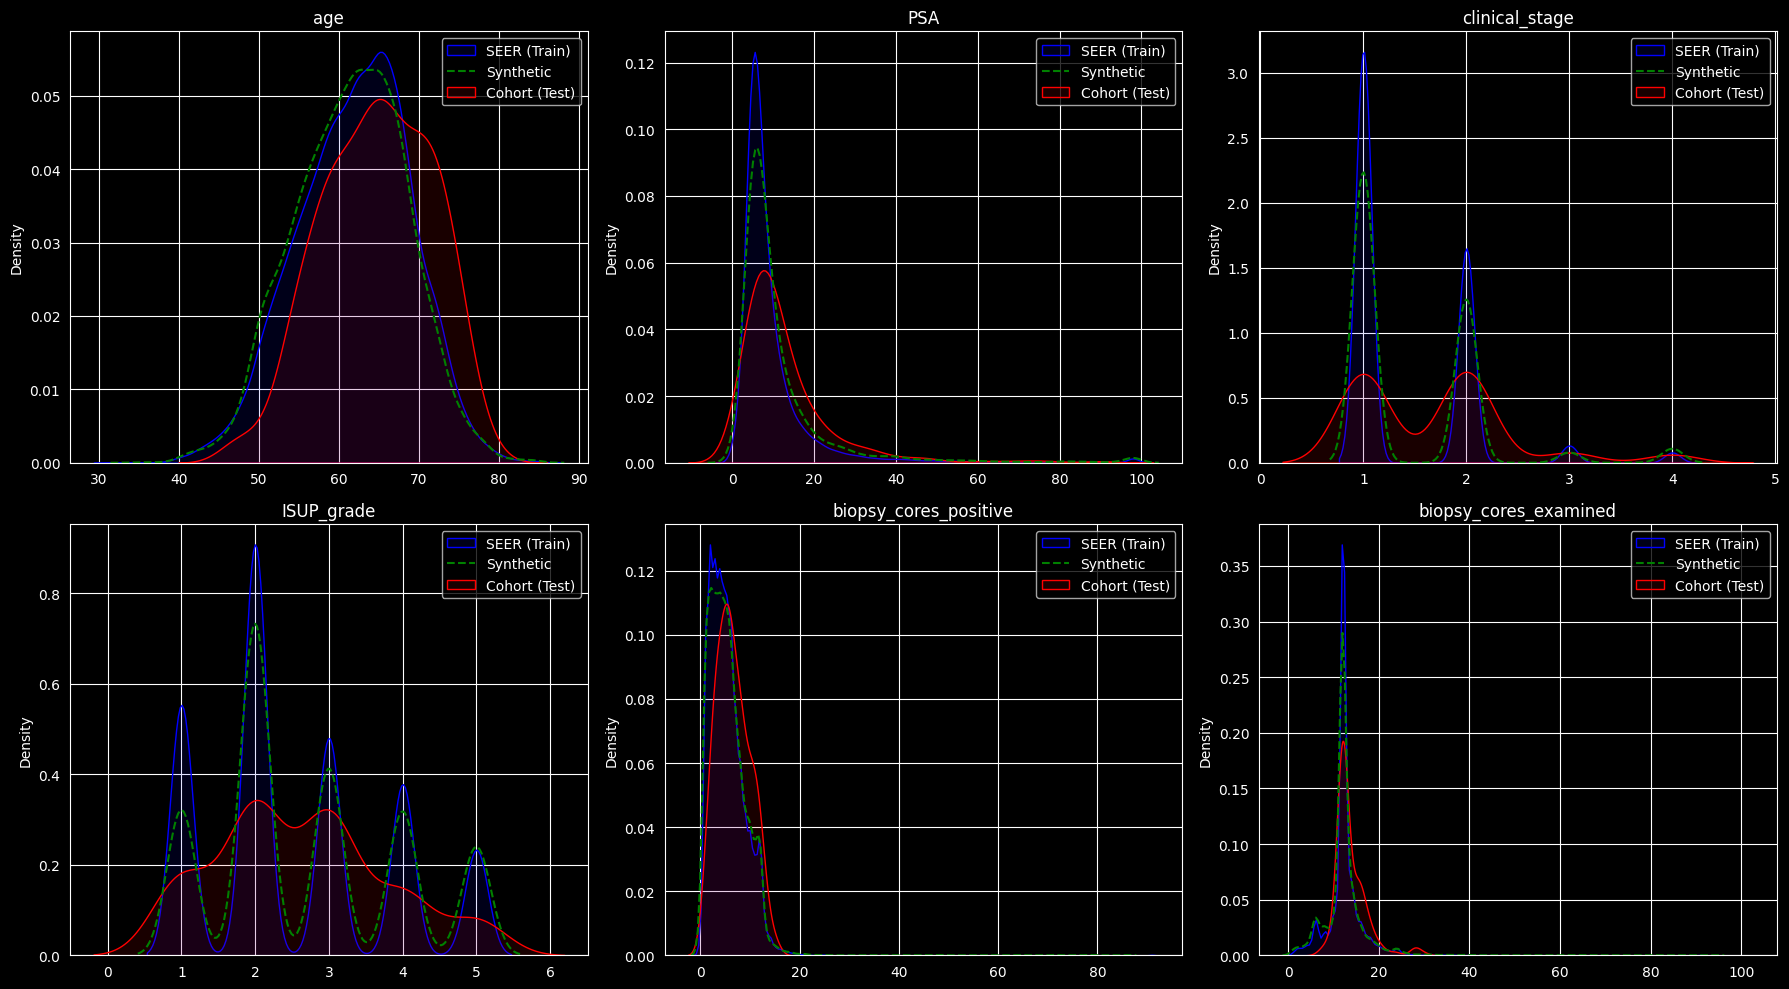

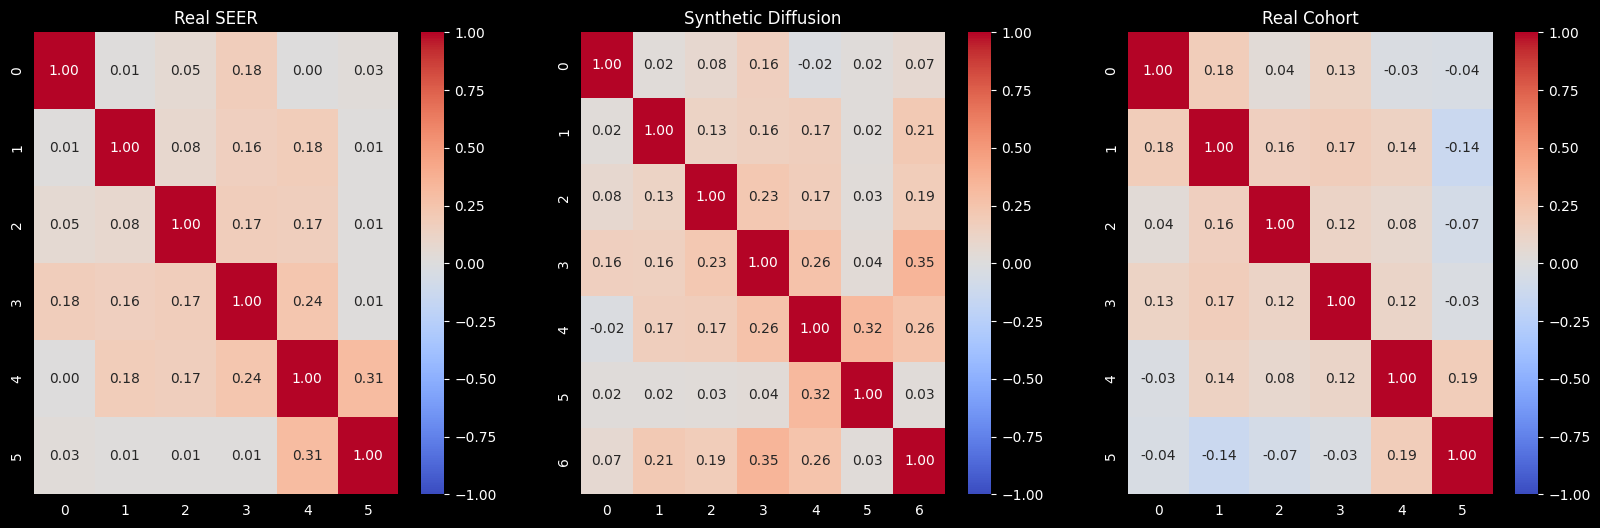

In [2]:
import math
import random
from os import path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.svm import SVC
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

SEED = 491
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = "../../data/previous"
seer_path = path.join(data_path, "processed_seer_with_age.csv")
cohort_path = path.join(data_path, "processed_cohort_with_age.csv")

seer = pl.read_csv(seer_path)
cohort = pl.read_csv(cohort_path)

label_col = "target"
int_cols = ["clinical_stage", "ISUP_grade", "biopsy_cores_positive", "biopsy_cores_examined"]
feature_cols = seer.select(pl.exclude(label_col)).columns
int_col_indices = [feature_cols.index(c) for c in int_cols]

X_seer = seer.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
y_seer = seer.get_column(label_col).to_numpy().astype(np.int64)
X_cohort = cohort.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
y_cohort = cohort.get_column(label_col).to_numpy().astype(np.int64)

qt = QuantileTransformer(output_distribution="normal", random_state=SEED)
X_seer_norm = qt.fit_transform(X_seer).astype(np.float32)

dataset = TensorDataset(
    torch.from_numpy(X_seer_norm).to(device),
    torch.from_numpy(y_seer).to(device)
)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class DiffusionMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=256, time_dim=64):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )
        self.label_emb = nn.Embedding(2, time_dim)
        self.input_proj = nn.Linear(in_dim, hidden_dim)

        self.block1 = nn.Sequential(nn.Linear(hidden_dim + time_dim, hidden_dim), nn.SiLU(), nn.LayerNorm(hidden_dim))
        self.block2 = nn.Sequential(nn.Linear(hidden_dim + time_dim, hidden_dim), nn.SiLU(), nn.LayerNorm(hidden_dim))
        self.block3 = nn.Sequential(nn.Linear(hidden_dim + time_dim, hidden_dim), nn.SiLU(), nn.LayerNorm(hidden_dim))
        self.output_proj = nn.Linear(hidden_dim, in_dim)

    def forward(self, x, t, y):
        t_emb = self.time_mlp(t)
        y_emb = self.label_emb(y)
        c_emb = t_emb + y_emb
        h = self.input_proj(x)
        h = self.block1(torch.cat([h, c_emb], dim=1))
        h = self.block2(torch.cat([h, c_emb], dim=1))
        h = self.block3(torch.cat([h, c_emb], dim=1))
        return self.output_proj(h)


class DiffusionProcess:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=0.02):
        self.T = T
        self.betas = torch.linspace(beta_start, beta_end, T).to(device)
        self.alphas = 1. - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
        self.sqrt_one_minus_alphas_bar = torch.sqrt(1. - self.alphas_bar)

    def q_sample(self, x0, t, noise=None):
        if noise is None: noise = torch.randn_like(x0)
        return (
                self.sqrt_alphas_bar[t].view(-1, 1) * x0 +
                self.sqrt_one_minus_alphas_bar[t].view(-1, 1) * noise
        ), noise

    @torch.no_grad()
    def p_sample(self, model, x, t, y, t_index):
        beta_t = self.betas[t_index]
        alpha_t = self.alphas[t_index]
        alpha_bar_t = self.alphas_bar[t_index]
        pred_noise = model(x, t, y)
        mean = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * pred_noise)
        if t_index == 0: return mean
        posterior_var = (1 - self.alphas_bar[t_index - 1]) / (1 - alpha_bar_t) * beta_t
        noise = torch.randn_like(x)
        return mean + torch.sqrt(posterior_var) * noise


diff_model = DiffusionMLP(X_seer_norm.shape[1]).to(device)
process = DiffusionProcess()
optimizer = optim.AdamW(diff_model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

print("Training Diffusion Model...")
for epoch in range(200):
    diff_model.train()
    epoch_loss = 0
    for x, y in dataloader:
        t = torch.randint(0, process.T, (x.shape[0],), device=device).long()
        noise = torch.randn_like(x)
        x_noisy, _ = process.q_sample(x, t, noise)
        pred_noise = diff_model(x_noisy, t, y)
        loss = loss_fn(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

n_syn = 10000
cohort_prevalence = np.mean(y_cohort)
n_pos = int(n_syn * cohort_prevalence)
n_neg = n_syn - n_pos

syn_labels = torch.cat([torch.zeros(n_neg), torch.ones(n_pos)]).long().to(device)
syn_labels = syn_labels[torch.randperm(n_syn)]
syn_x = torch.randn(n_syn, X_seer_norm.shape[1]).to(device)

diff_model.eval()
print(f"Generating {n_syn} samples...")
for i in reversed(range(process.T)):
    t = torch.full((n_syn,), i, device=device).long()
    syn_x = process.p_sample(diff_model, syn_x, t, syn_labels, i)

X_syn_raw = qt.inverse_transform(syn_x.cpu().numpy())
for idx in int_col_indices:
    X_syn_raw[:, idx] = np.round(X_syn_raw[:, idx])
    if feature_cols[idx] == "ISUP_grade":
        X_syn_raw[:, idx] = np.clip(X_syn_raw[:, idx], 1, 5)

syn_df = pl.DataFrame(X_syn_raw, schema=feature_cols).with_columns(pl.Series(label_col, syn_labels.cpu().numpy()))

scaler = StandardScaler()
X_train = scaler.fit_transform(syn_df.select(pl.exclude(label_col)).to_numpy())
y_train = syn_df.get_column(label_col).to_numpy()
X_test = scaler.transform(X_cohort)

svm = SVC(probability=True, class_weight='balanced', random_state=SEED)
svm.fit(X_train, y_train)
y_prob = svm.predict_proba(X_test)[:, 1]

p, r, t = precision_recall_curve(y_cohort, y_prob)
f1_scores = (2 * p * r) / (p + r + 1e-8)
best_thresh = t[np.argmax(f1_scores[:-1])]
y_pred = (y_prob >= best_thresh).astype(int)

print("-" * 30)
print(f"Diffusion Model Results on Real Cohort")
print(f"Threshold: {best_thresh:.4f}")
print(f"AUC:       {roc_auc_score(y_cohort, y_prob):.4f}")
print(f"Accuracy:  {accuracy_score(y_cohort, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_cohort, y_pred):.4f}")
print(f"Precision: {precision_score(y_cohort, y_pred):.4f}")
print(f"Recall:    {recall_score(y_cohort, y_pred):.4f}")
print("-" * 30)

real_seer_df = pl.DataFrame(X_seer, schema=feature_cols)
real_cohort_df = pl.DataFrame(X_cohort, schema=feature_cols)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(feature_cols):
    sns.kdeplot(real_seer_df[col], ax=axes[i], color='blue', label='SEER (Train)', fill=True, alpha=0.1)
    sns.kdeplot(syn_df[col], ax=axes[i], color='green', label='Synthetic', linestyle='--')
    sns.kdeplot(real_cohort_df[col], ax=axes[i], color='red', label='Cohort (Test)', fill=True, alpha=0.1)
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
sns.heatmap(real_seer_df.corr(), annot=True, fmt=".2f", ax=ax[0], cmap='coolwarm', vmin=-1, vmax=1)
ax[0].set_title("Real SEER")
sns.heatmap(syn_df.corr(), annot=True, fmt=".2f", ax=ax[1], cmap='coolwarm', vmin=-1, vmax=1)
ax[1].set_title("Synthetic Diffusion")
sns.heatmap(real_cohort_df.corr(), annot=True, fmt=".2f", ax=ax[2], cmap='coolwarm', vmin=-1, vmax=1)
ax[2].set_title("Real Cohort")
plt.show()

### Interpretation of Diffusion Model Results

Diffusion model was highly effective at reproducing the training data distribution. As seen in the feature density plots, the synthetic data (green dashed line) tracks the SEER source data (blue line) almost perfectly, confirming that the generator successfully learned the underlying probability distribution of the general population.

However, when applied to the hospital cohort, the results highlight a significant **domain gap**:

* **Strong AUC (0.81):** The model correctly learned the relative risk factors (e.g., higher Grade = higher cancer risk), allowing it to rank patients effectively.
* **Low Precision (0.39) & F1 (0.51):** The model struggles with calibration. The density plots reveal that the hospital cohort (red line) represents a much "sicker" population, with significantly higher PSA levels and clinical stages than the SEER population. Because the model was trained on the "healthier" general population, it tends to flag high-risk features more aggressively than necessary for this specific high-risk group cohort, leading to many false positives.